# Simplicial Complex Analysis

<span style='color:Red'>Stretch goal: Get a system to determine ecological state of a shape</span> <br>
<span style='color:Red'> Currently using the largest number of nodes in each shape for ordering. <br> TODO: allow for user to change ordering style in the results of the get shapes function.</span> <br> 
Written by Frederick Miller, Casey McKean, and Wako Bungula. <br> 
The kepler mapper object gives an output that is not easily navigatible. To resolve this, we wish to create shapes that are easier to navigate and understand, and reveal the data inside of them. <br>
We generate all the shapes in the simplicial complex, condense 1-simplices where possible, and obtain summary statistics on the shapes and the nodes within the shapes.

Here, what is mostly contained is demonstrations of what the functions do. For specific analysis, wrappers that are very similar to these applications will likely be used.

In [1]:
import numpy as np
import pandas as pd 
import queue
import animation
import json
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
pd.set_option('display.max_rows', None)
import pickle
print("Imports Done")

Imports Done


# File paths, `.p`, and `.json` import

From the `kmapper_demo` file, I added one extra code block to place the resulting simplicial complices in a `.json` file, which is a way to store dictionaries in long term storage. Additionally, it stores the dictionary of dataframes in a `.p` file, which is similar. The code below only needs to have the file paths changed, and then it will read the simplicial complices generated from kepler mapper. <br>
Here, we also import the actual data set, with data interpolated for the specific pool. <br>
Lastly, a list of the 11 continuous variables (the interpolated versions) is created.

In [2]:
jsonFilePath = r"C:\Users\killiad\Documents\Senior\REU\Mapper\PCA_1_NO_COND\TDA1PCA15Cubes35perc.json"
jsonFile = open(jsonFilePath, "r")
jsonData = json.load(jsonFile) 
jsonFile.close()

dataFilePath = r"C:\Users\killiad\Documents\Senior\REU\Mapper\PCA_1_NO_COND\TDA1PCA15Cubes35perc.p"
df_dict = pickle.load(open(dataFilePath, "rb"))

variables = ["PredictedWDP", "PredictedSECCHI", "PredictedTEMP", "PredictedDO", 
           "PredictedTURB", "PredictedVEL", "PredictedTP", #"PREDICTED_COND",
           "PredictedTN", "PredictedSS", "PredictedCHLcal"]

variables = ["PREDICTED_WDP", "PREDICTED_SECCHI", "PREDICTED_TEMP", "PREDICTED_DO", 
           "PREDICTED_TURB", "PREDICTED_VEL", "PREDICTED_TP", #"PREDICTED_COND",
           "PREDICTED_TN", "PREDICTED_SS", "PREDICTED_CHLcal"]

variables = ["WDP", "SECCHI", "TEMP", "DO", 
           "TURB", "VEL", "TP", #"COND",
           "TN", "SS", "CHLcal"]



print("Json file imported")

print(len(jsonData.keys()))

Json file imported
15


# Functions
See the `docstring`'s for what each function does and how it works.

In [3]:
def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex)
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def shapeDataSummary(scomplex, shape, df, variables, verbose = False):
    """
    Generates summary statistics of the given variables for a given shape in the simplicial.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex) at this function call.
    df: the entire dataframe
    variables: the variables of interest
    verbose: Determines if the function will print out extra information. False by default
    
    Description:
    1. Create an empty result dataframe to store the summary statistics.
    2. Get the sub dataframe (see getSubdf) for the particular shape
    3. For each variable we are analzying, generate summary statistics from the sub dataframe and place them
    inside the result dataframe.
    4. Return the result dataframe
    
    NOTE: this only creates summaries for one particular shape. In executing this method, it is done for each shape 
    outside of the function.
    
    """
    result = pd.DataFrame()
    if verbose == True:
        print("Obtaining sub dataframe for: ", shape)
        print("The number of nodes in this shape is: ", len(shape))
    subdf = getSubdf(scomplex, shape, df)
    if verbose == True:
        print("The number of datapoints in this shape is: ", subdf.shape[0])
    for var in variables:
        result[var] = subdf[var].describe()
    return result
    
    

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result


        
    
def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def nodeDataSummary(node, scomplex, variables,df):
    """
    Returns a data summary of a particular node
    params:
    node: node in question
    scomplex: The entire simplicial complex
    variables: The variables to obtain summaries
    df: the entire dataframe 
    
    description:
    1. Creates a result dataframe
    2. Get all the indices from the node from the simplicial complex
    3. Generate summaries for each variable
    4. Return the result
    """
    result = pd.DataFrame()
    if isinstance(node, list):
        print("Node is a list and thus cannot get summary information: ", node)
        indices = scomplex.get('nodes').get(node[0])
        subdf = df.loc[indices]
        for var in variables:
            result[var] = subdf[var].describe()
        return result
    
        
    indices = scomplex.get('nodes').get(node)
    subdf = df.loc[indices]
    for var in variables:
        result[var] = subdf[var].describe()
    return result
    
    
def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes


def getBoxplots(subdf, shape, key,filePath):
    """
    Generates box plots for 10 of the 11 continuous variables
    NOTE: CONDUCTIVITY IS NOT INCLUDED
    
    params:
    subdf: the sub dataframe of the particular shape
    shape: the shape in question
    key: what strata year season combo we are looking at 
    filePath: the output file path for all the box plots 
    
    description:
    clears the current plot 
    generates the sub dataframes for the respective variables.
    the reason they are grouped is based upon the numerical outputs for making the boxplots readable
    create a box plot, and then save it based upon the file path
    clear the plot
    repeat for the second set of variables
    """
    plt.clf()
    varDf1 = subdf[["PREDICTED_SS","PREDICTED_TURB","PREDICTED_TEMP","PREDICTED_CHLcal","PREDICTED_SECCHI"]]
    varDf2 = subdf[["PREDICTED_TP","PREDICTED_TN","PREDICTED_DO","PREDICTED_VEL","PREDICTED_WDP"]]
    plot1 = varDf1.boxplot(rot = 45)
    plt.savefig(filePath + "\\" + key +"_" + str(shape)  + "_SS_TURB_CHLcal"  + ".png")
    plt.clf()
    plot2 = varDf2.boxplot(rot = 45)
    plt.savefig(filePath + "\\" + key +"_" + str(shape)  + "_" + "TP_TN_VEL_etc" + ".png")
    return plot1, plot2

def determineOverlap(scomplex, shape, verbose = True):
    """
    Determines the overlap within a shape. 
    
    For each node, find it's neighbors, and generate the intersection, and saving the result without
    duplicates through utlizing the set functionality of python.
    
    params:
    scomplex: the entire simplicial complex in question
    shapes: all the shapes
    verbose: see prinout as the code works
    """
    
    result = set()
    if verbose:
        print("Shape: ", shape)
    nodes = scomplex.get('nodes')
    for node in shape:
        # currently, this displays a lot of repeats. 
        A = set(nodes.get(node))
        if verbose:
            print("Node: " , node  , " | Indices: ",A)
        B = adjacent(node, scomplex)
        if verbose:
            print("Adjacent nodes: ",B)
        for b in B:
            bSet = set(nodes.get(b))
            name = str(node) + " -> " + str(b) +": "
            intersection = set(A.intersection(bSet))
            intersection.add(name)
            intersection = frozenset(intersection)
            result.add(intersection)
            if verbose:
                print("Node: ", b, " | Indices: ", bSet)
                print("Overlap is: ", A.intersection(bSet))
    return result
print("Functions loaded")

Functions loaded


# Generating Summary Statistics on the entire simplicial complex
For each `mapper` output from `kepler-mapper`, we can generate the summary statistics for each of the continuous variables. This is done by first obtaining a list of the keys from the `.json` file, and then iterating through each complex, generating the shape and obtaining data summaries on each shape.

In [ ]:
allComplices = list(jsonData.keys())
for key in allComplices[0:3]: # remove indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = jsonData.get(key)
    shapes = clean_getShapes(scomplex)
    for shape in shapes:
        summaries = shapeDataSummary(scomplex, shape, df_dict.get(key), variables, verbose = False)
        if summaries.loc['count'][0] > 5 and len(shape)  > 2: # at least 6 datapoints and 3 nodes to see info
            print("The shape is: ",shape)
            print("The number of nodes in the shape is: ", len(shape))
            display(summaries) # Uncomment to see summaries

# Analyzing the largest structure per simplicial complex
Largest = Node count of the shape. The largest structure is likely to be the dominant feature of the stratum during this particular time period. As such, it is important to analyze the nodes within it. To do this, we generate all the shapes, and since the shapes are returned in descending order of the number of nodes per shape, we pull the first shape. From here, we can preform an analysis on each one.

In [ ]:
allComplices = list(jsonData.keys())

for key in allComplices[0:3]: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = jsonData.get(key)
    largestShape = clean_getShapes(scomplex)[0]
    nodes = scomplex.get('nodes')
    print("Largest shape is: ", largestShape)
    print("Number of nodes is: ", len(largestShape))
    for node in largestShape:
        summary = nodeDataSummary(node, scomplex,variables,df_dict.get(key))
        if summary.loc['count'][0] > 5: # 5 is chosen arbitraily
            print("Information for: ", node)
            display(summary)

# Condensing 1-simplices
Currently, many one simplices that we have contain information that means one of them is a subset of the other. To resolve this, we replace them with one cluster with all the indices in one node.

This is stored in the function `clean_getShapes(scomplex)` function. Below is a comparison of running the two functions

Below is a demonstration of what this function does to show why it is preferred over the original `getShapes` function.

In [ ]:
allComplices = list(jsonData.keys())
print("Standard shape version")
for key in allComplices[0:1]:
    print("Current Simplical Complex: ", key)
    scomplex = jsonData.get(key)
    nodes = scomplex.get('nodes')
    shapes = getShapes(scomplex)
    for shape in shapes:
        indices = []
        for node in shape:
            indices.append(nodes.get(node))
        indices = list(set([item for sublist in indices for item in sublist]))
        print(str(shape) + " : " + str(indices))

print("Clean shape version")
for key in allComplices[0:1]:
    print("Current Simplical Complex: ", key)
    scomplex = jsonData.get(key)
    nodes = scomplex.get('nodes')
    cleanShapes = clean_getShapes(scomplex)
    for shape in cleanShapes:
        indices = []
        npShape = np.array(shape).flatten()
        for node in npShape:
            indices.append(nodes.get(node))
        indices = list(set([item for sublist in indices for item in sublist]))
        print(str(shape) + " : " + str(indices))

# Box plot per shape
Here, we generate box plots for the variables of interest. for each shape in the simplicial complex

In [ ]:
allComplices = list(jsonData.keys())
for key in allComplices[0:1]: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = jsonData.get(key)
    shapes = clean_getShapes(scomplex)
    print("number of shapes: ", len(shapes))
    for shape in shapes:
        """
        Hello whoever is using this function
        getBoxplots takes a couple arguments. 
        the big thing that matters here is the 
        strataYear variable. Essentially, the key that allows us to access each simplicial complex is weird.
        Depending on your file system, using the str(key) conversion may cause errors. to resolve this, 
        below is a potential example. Feel free to change it as you go for your use.
        """
        strataYear = str(key).replace(" ","-").replace(":","").replace("[","").replace("]","").replace("'","")
        print(strataYear)
        """
        before: 
        ['Stratum 1 SUMMER 93-00: ']
        after:
        Stratum-1-SUMMER-93-00-
        """
        subdf = getSubdf(scomplex, shape, df_dict.get(key))
        plots = getBoxplots(subdf, shape, strataYear,  
                            filePath = r"C:\Users\forre\Desktop\REU\TDA\Data\TDAOutputs\Boxplots")


# Discovering which indices within the nodes overlap
This code will determine what points in the nodes are overlapping within two nodes. This can have applications to see what is similar between the nodes, and potentially determine the "width" of the edges between two nodes. 

In [ ]:
allComplices = list(jsonData.keys())
for key in allComplices[0:1]: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = jsonData.get(key)
    shapes = clean_getShapes(scomplex)
    print("number of shapes: ", len(shapes))
    result = list(determineOverlap(scomplex, shapes[0], verbose = False))
    print("Shape: ", shapes[0])
    # todo: Currently, result double counts. prevent that.
    for item in result:
        itemList = list(item)
        for a in itemList:
            if isinstance(a, str):
                print(a)
        s = []
        for b in itemList:
            if isinstance(b, int):
                s.append(b)
        print(s)

# See compare shapes over the years
NOTE: Comparing the largest shape in each.

Modifying what complices can be seen and normalizing the variables, we can generate many box plots to see what variables are changing over time in the largest shape.

In [ ]:
allComplices = list(jsonData.keys())
allComplices = ["['Stratum 1 SUMMER 93-00: ']",
               "['Stratum 1 SUMMER 98-04: ']",
               "['Stratum 1 SUMMER 01-13: ']",
                "['Stratum 1 SUMMER 10-16: ']",
                "['Stratum 1 SUMMER 14-20: ']"
               ] # just looking at one year

for key in allComplices:
    print(key)
    temp = pd.DataFrame()
    scomplex = jsonData.get(key)
    data = df_dict.get(key)
    shape = clean_getShapes(scomplex)[0]
    print(shape)
    subdf = getSubdf(scomplex, shape, data)
    print(data.shape[0])
    subdfCopy = subdf.copy()
    for var in variables:
        subdfCopy[var] =  subdfCopy[var]/subdfCopy[var].max()
    for var in variables:
        
        temp[var] = subdfCopy[var].describe()
    display(temp)
    strataYear = str(key).replace(" ","-").replace(":","").replace("[","").replace("]","").replace("'","")
    print(strataYear)
    getBoxplots(subdfCopy, shape, strataYear,filePath = r"C:\Users\forre\Desktop\REU\TDA\Data\TDAOutputs\Stratum1Box")

# Calculating Density for Nodes in the Largest Structure
Note that density is jsonData

In [58]:
def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)  

In [59]:
allComplices = list(jsonData.keys())

for key in allComplices: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = jsonData.get(key)
    scomplex['density'] = {}
    largestShape = clean_getShapes(scomplex)[0]
    print("Largest shape is: ", largestShape, "\n")
    largestShape_df = getSubdf(scomplex, largestShape, df_dict.get(key))
    k = int((df_dict.get(key).shape[0] / 10) + 1)
    for node_name in largestShape:
        scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)

Current Simplical Complex:  ['Stratum 1 SUMMER 93-00: ']
Largest shape is:  ['cube4_cluster0', 'cube5_cluster0', 'cube2_cluster0', 'cube0_cluster0', 'cube1_cluster1', 'cube1_cluster0', 'cube8_cluster0', 'cube3_cluster1', 'cube7_cluster0', 'cube6_cluster0'] 

Current Simplical Complex:  ['Stratum 2 SUMMER 93-00: ']
Largest shape is:  ['cube3_cluster0', 'cube2_cluster1', 'cube4_cluster1', 'cube2_cluster0', 'cube3_cluster4', 'cube0_cluster0', 'cube1_cluster0'] 

Current Simplical Complex:  ['Stratum 3 SUMMER 93-00: ']
Largest shape is:  ['cube4_cluster29', 'cube3_cluster0', 'cube2_cluster1', 'cube2_cluster0', 'cube0_cluster0', 'cube4_cluster13', 'cube1_cluster0', 'cube4_cluster20'] 

Current Simplical Complex:  ['Stratum 1 SUMMER 98-04: ']
Largest shape is:  ['cube4_cluster0', 'cube3_cluster0', 'cube5_cluster0', 'cube4_cluster1', 'cube2_cluster0', 'cube0_cluster0', 'cube1_cluster0', 'cube6_cluster0'] 

Current Simplical Complex:  ['Stratum 2 SUMMER 98-04: ']
Largest shape is:  ['cube2_clu

In [49]:
jsonData["['Stratum 1 SUMMER 93-00: ']"]['links']

{'cube0_cluster0': ['cube1_cluster0'],
 'cube1_cluster0': ['cube2_cluster0'],
 'cube1_cluster1': ['cube2_cluster0'],
 'cube2_cluster0': ['cube3_cluster1'],
 'cube3_cluster1': ['cube4_cluster0'],
 'cube4_cluster0': ['cube5_cluster0'],
 'cube5_cluster0': ['cube6_cluster0'],
 'cube5_cluster1': ['cube6_cluster2'],
 'cube6_cluster0': ['cube7_cluster0'],
 'cube7_cluster0': ['cube8_cluster0'],
 'cube8_cluster1': ['cube9_cluster1'],
 'cube9_cluster0': ['cube10_cluster2'],
 'cube9_cluster1': ['cube10_cluster1'],
 'cube11_cluster1': ['cube12_cluster0']}

# Creating the Directed Graph

In [60]:
def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

In [61]:
for key in allComplices: # remove the indices here to get all the strata for all the time periods
    scomplex = jsonData.get(key)
    largestShape = clean_getShapes(scomplex)[0]
    scomplex['graph'] = {}
    scomplex['graph'] = generate_graph(scomplex, largestShape)

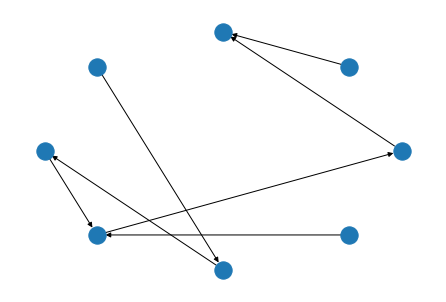

In [62]:
nx.draw_shell(jsonData["['Stratum 1 SUMMER 98-04: ']"]['graph'])